### POSTPROCESSING CORONARY ARTERY SEGMENTATIONS FOR CFD

In [1]:
import numpy as np 
import re
import matplotlib.pyplot as plt
import cc3d
import nrrd
import time
from skimage.morphology import skeletonize, medial_axis, thin, cube, ball, disk, octahedron, binary_dilation
from skimage.segmentation import watershed
from pathlib import Path
from scipy.ndimage import correlate,  distance_transform_edt
from IPython.display import clear_output
from skimage.morphology import convex_hull_image

In [2]:
def read_img(imgpath):
    """
    Reads an image as a nifti file from a given path, supporting both NRRD and NIfTI formats.
    Fixes also affine and header for later saving to nifti. 
    """
    imgpath = str(imgpath)
    if imgpath.endswith('.nrrd'):
        img, header = nrrd.read(imgpath)
        nifti_im = nib.Nifti1Image(img, None)  # create a NIfTI image with identity affine
        # Update the NIfTI header with necessary information
        tmp = np.eye(4)
        if 'space directions' in header:
            nifti_im.header.set_zooms(np.diag(header['space directions']))
            tmp[:-1,:-1] = header['space directions']
        if 'space origin' in header:
            tmp[:-1,-1] = header['space origin']
        tmp[:2,:]*= -1  # flip x and y axes
        nifti_im.header.set_sform(tmp)
        nifti_im.header.set_data_dtype(img.dtype)
        return nifti_im
    
    elif imgpath.endswith('.nii') or imgpath.endswith('.nii.gz'):
        img = nib.load(imgpath)
        return img
    else:
        raise ValueError("Unsupported image format.")
    

First we extract the two largest components from the original segmentation to check how it looks. 
For the conference, I'll porbably only work with these. Later on, we can include some postprocessing with reconnection. 

In [3]:
import nibabel as nib
import nrrd 
#from TMDutils import read_img
from pathlib import Path
import re 

rootpath = Path('/Users/evabreznik/Desktop/CODING/test_predicted')
for modelfolder in ["SegMamba", "TotalSegmentator", "UMamba", "UNet", "UNetClDice"]:
    print(f"Processing folder: {modelfolder}")
    vseslike = [p for p in Path(rootpath, modelfolder).glob("*") if p.name.endswith((".nrrd", ".nii.gz"))]
    for imgpath in vseslike:
        print(f".     {imgpath.name}")
        mask = read_img(imgpath) #will be loaded as nifti image

        labels_out, N = cc3d.connected_components(mask.get_fdata(), connectivity=26, return_N=True)
        stats = cc3d.statistics(labels_out)
        print(f".      Nr detected components: {N}")

        mainCCs = np.argsort(stats['voxel_counts'])[-3:-1]
        new_label = np.isin(labels_out, mainCCs) #.astype(np.uint16)
        nova = nib.Nifti1Image(new_label, mask.affine, mask.header)

        savename = "_".join(re.split("\.|_", imgpath.name)[:2])+"_"+"".join([i for i in modelfolder if i.isupper()])
        nib.save(nova, f'/Users/evabreznik/Desktop/CODING/test_predicted/onlymain/{savename}.nii.gz')

Processing folder: SegMamba
.     Normal_1.nii.gz
.      Nr detected components: 21
.     Diseased_9.nii.gz
.      Nr detected components: 4
.     Diseased_5.nii.gz
.      Nr detected components: 25
.     Normal_3.nii.gz
.      Nr detected components: 29
.     Normal_9.nii.gz
.      Nr detected components: 14
.     Diseased_18.nii.gz
.      Nr detected components: 8
.     Diseased_1.nii.gz
.      Nr detected components: 19
.     Normal_10.nii.gz
.      Nr detected components: 13
.     Diseased_19.nii.gz
.      Nr detected components: 28
.     Normal_4.nii.gz
.      Nr detected components: 16
Processing folder: TotalSegmentator
.     Normal_1.nii.gz
.      Nr detected components: 9
.     Diseased_9.nii.gz
.      Nr detected components: 3
.     Diseased_5.nii.gz
.      Nr detected components: 9
.     Normal_3.nii.gz
.      Nr detected components: 3
.     Normal_9.nii.gz
.      Nr detected components: 7
.     Diseased_18.nii.gz
.      Nr detected components: 8
.     Diseased_1.nii.gz
.   

Try to reconnect broken parts. Then get 2 largest connected components, save to new files (since these are the ones we will compare to in terms of errors).

(This should be joind later into "def get2CC(mask, image, savepath)")

In [30]:

rootpath = Path('/Users/evabreznik/Desktop/CODING/test_predicted')
for modelfolder in [ "UMamba", "UNet", "UNetClDice"]: #"SegMamba", "TotalSegmentator",
    print(f"Processing folder: {modelfolder}")
    vseslike = [p for p in Path(rootpath, modelfolder).glob("*") if p.name.endswith((".nrrd", ".nii.gz"))]
    for imgpath in vseslike:
        print(f".     {imgpath.name}")
        mask = read_img(imgpath) #will be loaded as nifti image
        basename = "_".join(re.split("\.|_", imgpath.name)[:2])
        image = read_img(f"/Users/evabreznik/Desktop/MAIASTUFF/nnUNet_raw/Dataset666_ASOCA/imagesTs/{basename}_0000.nrrd")

        labels_out, _ = cc3d.connected_components(mask.get_fdata(), connectivity=26, return_N=True)
        new_label = reconnect_broken(image.get_fdata(), labels_out, minvolume=50, dist=10, direction_k=3, reconn_method="frangi")

        nova = nib.Nifti1Image(new_label, mask.affine, mask.header)

        savename = basename+"_"+"".join([i for i in modelfolder if i.isupper()])
        nib.save(nova, f'/Users/evabreznik/Desktop/CODING/test_predicted/reconnected/{savename}.nii.gz')

Processing folder: UMamba
.     Diseased_5.nrrd
Candidates for reconnection: [3, 14, 13, 5, 8, 2, 26, 11, 15, 4, 1]
so many neighbors found:  3
so many neighbors found:  3
Candidate 3 not close enough main CC
so many neighbors found:  3
so many neighbors found:  3
Reconnecting 14 at (10, 10, 10) to (10, 11, 11)
so many neighbors found:  3
so many neighbors found:  3
Candidate 13 not close enough main CC
Unreasonable amount endpoints found for candidate 5: 0. Handling not implemented.
so many neighbors found:  3
so many neighbors found:  3
Candidate 8 not close enough main CC
Not enough previous voxels found for candidate 2 at endpoint [275 398   1]. Skipping.
so many neighbors found:  3
Candidate 2 not close enough main CC
so many neighbors found:  3
so many neighbors found:  3
Candidate 26 not close enough main CC
so many neighbors found:  3
so many neighbors found:  3
Reconnecting 11 at (10, 10, 10) to (11, 11, 12)
so many neighbors found:  3
so many neighbors found:  4
Candidate 15 

In [29]:
import numpy as np
from skimage.filters import frangi, sato
import numpy as np
from skimage.draw import line_nd
from skimage.graph import route_through_array


def endpoint_direction(skeleton_coords, k=3):
    """
    Estimate direction at a skeleton endpoint.
    skeleton_coords: a ~2k x 2k x 2k cutout of the 
    skeleton array around the endpoint. Endpoint 
    should be in the middle. It will be internally 
    transformed into a Nx3 array of (z,y,x) skeleton 
    voxel coordinates. Endpoint is (l//2,l//2,l//2) where 
    l is the length of the cutout.
    k: number of neighbor voxels to consider
    """
    l = len(skeleton_coords) #assume it's a cube cutout around the 
    #endpoint, should also be at least 2k per side
    endpoint = np.array([l,l,l])
    skeleton_coords = np.argwhere(skeleton_coords)  # convert to array of coordinates if needed
    print("so many neighbors found: ",len(skeleton_coords)-1)
    # compute distances from endpoint to all skeleton voxels
    dists = np.linalg.norm(skeleton_coords - endpoint, axis=1)
    
    # get the k+1 closest voxels (this includes the endpoint itself)
    idx = np.argsort(dists)[1:k+1]  # skip endpoint itself
    neighbors = skeleton_coords[idx]
    
    # vector(s) from endpoint to neighbors
    vecs = neighbors - endpoint
    
    # do PCA on neighbor vectors
    u, s, vh = np.linalg.svd(vecs, full_matrices=False)
    direction = vh[0]  # principal component
    
    return direction / np.linalg.norm(direction)


def angle_between(v1, v2):
    v1 = v1 / (np.linalg.norm(v1)+1e-8)
    v2 = v2 / (np.linalg.norm(v2)+1e-8)
    return np.arccos(np.clip(np.dot(v1, v2), -1.0, 1.0))


def endpoint_points_towards(main_coords, direction, max_angle=np.pi/4):
    """
    Check if skeleton endpoint points towards main tree.
    main_coords: the bounding box (cube) cutout (within a reasonable reconnection 
    distance from the endpoint), so that (l/2,l/2,l/2) is the endpoint 
    (where l=len(main_coords)), and the cutout contains ONLY reconnection candidates, 
    ie points from main vessels. WIll be internally converted to Mx3 array of (z,y,x) 
    coords of main tree inside cutout.
    direction: normalized vector from endpoint (from PCA/neighboring skeleton)
    max_angle: angle threshold (radians)
    """
    s = main_coords.shape # assuming main_coords is a cutout
    endpoint = np.array([s[0]//2, s[1]//2, s[2]//2])  # assuming cutout is centered at endpoint
    main_coords = np.argwhere(main_coords)
    #for the purpose of sorting by distance and angle, let's assume the bb is basiclly cube, and 
    # take average length of the cutout as a reference length
    l = np.mean(s)

    # for each candidate, check alignment
    candidates = []
    for cand in main_coords:
        vec = cand - endpoint
        ang = angle_between(direction, vec)
        if ang < max_angle:
            candidates.append((cand, ang, np.linalg.norm(vec)))
    if len(candidates)>0:
        #get the closest candidate. 
        #closest = min(candidates, key=lambda x: x[2])  # min by distance
        best = min(candidates, key=lambda x: x[2]/l + 2*l*x[1]/np.pi)  # min by relative distance and angle
        return True, best
    return False, None


def make_cost_map(image, method="intensity", weight=1.0):
    eps = 1e-6
    if method == "intensity":
        cost = weight / (image.astype(np.float32) + eps)
    elif method == "frangi":
        vesselness = frangi(image.astype(np.float32))
        cost = weight / (vesselness + eps)
    elif method == "sato":
        vesselness = sato(image.astype(np.float32))
        cost = weight / (vesselness + eps)
    else:
        raise ValueError(f"Unknown cost method {method}")
    return cost

def reconnect(endpoint, target, method="straight", image=None, cost_weight=1.0):
    """
    Reconnects two voxels in 3D.
    ----------
    endpoint : (z,y,x) tuple Start voxel coordinate
    target : (z,y,x) tuple End voxel coordinate
    method : str, "straight" or "intensity", "frangi", "sato" (to do minpath)
    image : ndarray, 3D image (cutout). Required if method="minpath"
    cost_weight : float, scaling factor for cost (higher -> straighter, lower -> more intensity-driven)
    -------
    out:: list of (z,y,x) voxels along the reconnection path
    """
    endpoint = tuple(map(int, endpoint))
    target   = tuple(map(int, target))
    
    if method == "straight":
        # Rasterize a straight 3D line
        coords = list(zip(*line_nd(endpoint, target)))
        return coords

    elif method in ["sato", "frangi", "intensity"]:
        if image is None:
            raise ValueError("Image is required for minpath methods.")
        # Define cost
        cost = make_cost_map(image, method=method, weight=cost_weight)
        # Compute path
        path, _ = route_through_array(cost, start=endpoint, end=target, fully_connected=True)
        return path
    
    else:
        raise ValueError(f"Unknown method {method}")


def reconnect_broken(image, labels_out, minvolume=50, dist=10, direction_k=3, reconn_method="frangi"):
    """ Tries to reconnect broken parts of the coronary artery segmentation."""
    
    stats = cc3d.statistics(labels_out)
    components = np.argsort(stats['voxel_counts'])[:-1]
    mains = components[-2:]  # last two are the largest components, which are L and R
    candidates = [i for i in components[:-2] if stats['voxel_counts'][i] > minvolume]
    if len(candidates) == 0:
        print("No candidates for reconnection found.")
        return labels_out
    print(f"Candidates for reconnection: {candidates}")

    for can in candidates:
        # Implement your reconnection logic here
        skel = skeletonize(labels_out == can)
        #get endpoints, direction, and check if any main component (L,R) within a reasonable distance/bounding box. 
        endpoints = [pt for pt in np.argwhere(skel) if skel[pt[0]-1:pt[0]+2, pt[1]-1:pt[1]+2, pt[2]-1:pt[2]+2].sum()==2]
        if len(endpoints) != 2:
            print(f"Unreasonable amount endpoints found for candidate {can}: {len(endpoints)}. Handling not implemented.")
            continue  
        # get the directions at each endpoint, by looking at the direction_k past voxels in the 
        # skeleton leading up to the endpoint
        to_reconnect = []
        for pt in endpoints:
            # Get the 2 previous voxels in the skeleton. This should always be possible.
            #unless the segmentation was a major clusterfuck.
            prev_voxels = skel[pt[0]-direction_k:pt[0]+direction_k+1, pt[1]-direction_k:pt[1]+direction_k+1, pt[2]-direction_k:pt[2]+direction_k+1]
            if np.sum(prev_voxels) < direction_k+1:
                print(f"Not enough previous voxels found for candidate {can} at endpoint {pt}. Skipping.")
                continue
            dir = endpoint_direction(prev_voxels, k=direction_k)
            #now cutout a reasonable bb around the endpoint to alleviate the processing time, 
            # check if it contains L/R
            bb_expanded = [slice(max(0, pt[i] - dist), min(image.shape[i], pt[i] + dist)) for i in range(3)]
            bb_labels = labels_out[bb_expanded[0], bb_expanded[1], bb_expanded[2]]
            if (mains[0] in bb_labels) or (mains[1] in bb_labels):
                connect, which = endpoint_points_towards(bb_labels, dir, max_angle=np.pi/4)
                if connect:
                    to_reconnect.append((pt, which[0], bb_expanded))
        if len(to_reconnect) == 0:
            print(f"Candidate {can} not close enough main CC")
            continue
        #if we get here, we have at least one endpoint that can be connected to L or R
        #if there are multiple candidates, we can choose the closest one
        if len(to_reconnect) > 1:
            print(f"Multiple candidates for {can}, choosing closest.")
            pt, which, bb_expanded = min(to_reconnect, key=lambda x: x[1][2]/dist + 2*dist*x[1][1]/np.pi) #use dist as a proxy for l
        else:
            pt, which, bb_expanded = to_reconnect[0]
        #now before we reconnect, we need to transform the "which" coordinates back 
        # to the original coordinates, and make a cutout of the image
        which = which[0] + bb_expanded[0].start, which[1] + bb_expanded[1].start, which[2] + bb_expanded[2].start
        startx, starty, startz = max(min(which[0], pt[0])-dist, 0), max(min(which[1], pt[1])-dist, 0), max(min(which[2], pt[2])-dist, 0)
        endx, endy, endz = min(max(which[0], pt[0])+dist,image.shape[0]), min(max(which[1], pt[1])+dist, image.shape[1]), min(max(which[2], pt[2])+dist, image.shape[2])
        image_cutout = image[startx:endx, starty:endy, startz:endz]
        connected_to_label = labels_out[which[0], which[1], which[2]]
        #now we have the image cutout, and the coordinates of the endpoint and the target
        pt = (pt[0] - startx, pt[1] - starty, pt[2] - startz)
        which = (which[0] - startx, which[1] - starty, which[2] - startz)

        #now we have everything to reconnect. Reconnect either with a straight line or via energy minimization/shortest path
        #  based on the underlying CT. 
        print(f"Reconnecting {can} at {pt} to {which}")
        reconnect_path = reconnect(pt, which, method=reconn_method, image=image_cutout, cost_weight=1.0)
        #now we have the path, we can set the labels_out to the new label
        for p in reconnect_path:
            labels_out[startx + p[0], starty + p[1], startz + p[2]] = connected_to_label #this way, the new reconnected 
            #vessel will also be considered when computing other reconnections. 
    
    return labels_out

In [280]:
#LEts resample image to isotropic voxelsizes, so it'll be better for cfd
import numpy as np
from scipy.ndimage import zoom


def resample_array(array, voxel_size, is_mask=False):
    new_spacing = (min(voxel_size),) * 3

    zoom_factors = [s / ns for s, ns in zip(voxel_size, new_spacing)]
    order = 0 if is_mask else 1  # nearest for masks, linear for CT
    resampled = zoom(array, zoom_factors, order=order)
    return resampled, new_spacing



for modelfolder,ismask in zip([Path("/Users/evabreznik/Desktop/CODING/test_predicted/onlymain"),
                    Path("/Users/evabreznik/Desktop/MAIASTUFF/nnUNet_raw/Dataset666_ASOCA/labelsTs"),
                    Path("/Users/evabreznik/Desktop/MAIASTUFF/nnUNet_raw/Dataset666_ASOCA/imagesTs")],
                   [True, True, False]):
    print(f"Processing folder: {modelfolder.name}")
    vseslike = [p for p in modelfolder.glob("*") if p.name.endswith((".nrrd", ".nii.gz"))]
    for imgpath in vseslike:
        print(f".     {imgpath.name}")
        mask = read_img(imgpath) #will be loaded as nifti image, with appropriate header
        #now resample it, fix header again, and save
        mask_new, voxsize_new = resample_array(mask.get_fdata(), voxel_size=mask.header.get_zooms(), is_mask=ismask)
        new_header = nib.Nifti1Image(mask_new, None)  # create a NIfTI image with identity affine
        # Update the NIfTI header with necessary information
        tmp = mask.header.get_sform()
        new_header.header.set_zooms(voxsize_new)
        tmp[0,0] = -voxsize_new[0]
        tmp[1,1] = -voxsize_new[1]
        tmp[2,2] = voxsize_new[2]

        new_header.header.set_sform(tmp)
        new_header.header.set_data_dtype(mask.header.get_data_dtype())

        nib.save(new_header, f'/Users/evabreznik/Desktop/CODING/test_predicted/resampled/{imgpath.name.split(".")[0]}.nii.gz')




Processing folder: onlymain
.     Normal_1_TS.nii.gz
.     Normal_4_UNCD.nii.gz
.     Normal_10_TS.nii.gz
.     Diseased_1_UM.nii.gz
.     Diseased_18_UM.nii.gz
.     Diseased_5_SM.nii.gz
.     Diseased_5_UN.nii.gz
.     Normal_4_UN.nii.gz
.     Normal_4_SM.nii.gz
.     Normal_1_UNCD.nii.gz
.     Diseased_19_TS.nii.gz
.     Diseased_1_UNCD.nii.gz
.     Normal_9_UN.nii.gz
.     Normal_9_SM.nii.gz
.     Normal_3_SM.nii.gz
.     Normal_3_UN.nii.gz
.     Diseased_9_SM.nii.gz
.     Diseased_18_UNCD.nii.gz
.     Diseased_9_UN.nii.gz
.     Diseased_19_UM.nii.gz
.     Normal_1_UM.nii.gz
.     Normal_10_UM.nii.gz
.     Diseased_1_TS.nii.gz
.     Diseased_18_TS.nii.gz
.     Normal_4_UM.nii.gz
.     Diseased_9_TS.nii.gz
.     Normal_3_TS.nii.gz
.     Normal_10_UNCD.nii.gz
.     Diseased_9_UNCD.nii.gz
.     Normal_9_UM.nii.gz
.     Normal_9_UNCD.nii.gz
.     Diseased_5_UM.nii.gz
.     Diseased_5_UNCD.nii.gz
.     Diseased_18_SM.nii.gz
.     Diseased_1_UN.nii.gz
.     Diseased_1_SM.nii.gz
.     Dis

For now we work with the main 2CC (without reconnection; that will be tested after the conference, maybe for a comparison paper). 
Steps to do:

0. get largest 2CCs (now saved separately)
1. skeletonize to width 1vox
2. define branches and bifurcations; for each branch get length+width. 
3. remove the branches that are too small (too short or too thin. although the too thin part could be maybe avoided with good surface tracing?)
4. inflate MIB along the skeleton; do surface tracing along the vessel to remove irregularities; ie smoothing of a sort
5. set main inflow surface based on coarse aorta seg!


# 0. and 1. get CC and skeletonize

In [4]:
import nibabel as nib
import nrrd
import cc3d
from skimage.morphology import skeletonize, medial_axis

#ctimg, _ = nrrd.read("/Users/evabreznik/Desktop/MAIASTUFF/nnUNet_raw/Dataset666_ASOCA/imagesTs/Normal_9_0000.nrrd")
ctimg = nib.load("/Users/evabreznik/Desktop/CODING/test_predicted/resampled/Normal_9_0000.nii.gz").get_fdata()
img = nib.load("/Users/evabreznik/Desktop/CODING/test_predicted/resampled/Normal_9_TS.nii.gz")
voxelsize = img.header.get_zooms()[:3]
#we work with each CC separately.

ccs, ncomp = cc3d.connected_components(img.get_fdata(), connectivity=26, return_N=True)
assert ncomp == 2, f"Expected 2 components, got {ncomp}."

component = 1

mask = ccs==component #do 2 for the other one.
stats = cc3d.statistics(ccs)
bb = stats['bounding_boxes'][component]  # get bounding box of the second component/first foreground
bb = tuple(slice(max(ind.start-5, 0),  min(ind.stop+6, s), None) for ind, s in zip(bb, mask.shape))
voxels = stats['voxel_counts'][component]  # get voxel count of the second component/first foreground

#crop to bounding box
label = mask[bb[0], bb[1], bb[2]] 
#skeletonize to width 1vox
skel = skeletonize(label) 
#skel, distance = medial_axis(label, return_distance=True) #only works in 2D :( )

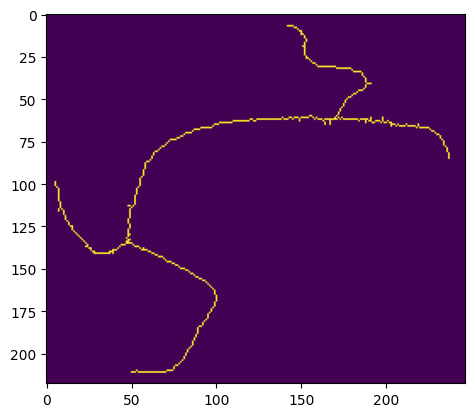

In [9]:
plt.figure()
plt.imshow(skel.max(axis=0))


# 2. define branches and branching points

In [ ]:
#get all branching points and leaves
leaves, bifur = [], []
skeleton = np.nonzero(skel)
for x,y,z in zip(*skeleton):
        num_ngbhs = skel[x-1:x+2, y-1:y+2, z-1:z+2].sum()
        if num_ngbhs==2:
            leaves.append((x,y,z))
        elif num_ngbhs>3:
            bifur.append((x,y,z))

cluster_tmp = np.zeros_like(skel, dtype=np.uint8)
cluster_tmp[*np.stack(leaves).T] = 1
cluster_tmp[*np.stack(bifur).T] = 1

clusters, Ncl = cc3d.connected_components(cluster_tmp, connectivity=26, return_N=True)
print("found", Ncl, "potential bifur clusters")
cluster_stats = cc3d.statistics(clusters)
#for each connected component, find the most reasonable point among them to be a bifur or leaf. 
bifur_points = []
leaf_points = []
for i in range(1, Ncl+1):
    size = cluster_stats['voxel_counts'][i]
    cluster_bb = cluster_stats['bounding_boxes'][i]
    if size==1:
        xyz = (cluster_bb[0].start, cluster_bb[1].start, cluster_bb[2].start)
        if xyz in bifur:
            bifur_points.append([xyz])
        elif xyz in leaves:
            leaf_points.append([xyz])
        #should be no else
    else:
        # take a cutout, but extended by 1 so you get neighbours. Which per defeinition will not be within the same cluster (dvs will not be bifur or leaf)
        zoom = clusters[cluster_bb[0].start-1:cluster_bb[0].stop+1, cluster_bb[1].start-1:cluster_bb[1].stop+1, cluster_bb[2].start-1:cluster_bb[2].stop+1]==i
        skelzoom = skel[cluster_bb[0].start-1:cluster_bb[0].stop+1, cluster_bb[1].start-1:cluster_bb[1].stop+1, cluster_bb[2].start-1:cluster_bb[2].stop+1]
        #remove the voxels that belong ot this bifur/leaf, so you dont count htem as neighbors
        skelzoom = skelzoom - 1*zoom #both are binary, so this will remove the voxels that are in the cluster
        #find out which of the voxels is the best as a bifur/leaf point.
        #OBS: if ANY of the voxels are a leaf, then the point we get out should be a leaf too!  ## TODO: not really? try removing the leaf; if the bifur point is still the same, then it's a bifur.
        isleaf = np.any(clusters[*np.stack(leaves).T]==i) #bool

       # save the cluster; ie all voxels that belong ot this bifur/leaf, so you can grow from that when following the tree. 
       # but you can skip those voxels that are only neighbouring on other voxels form the clusters; dvs save only those that 
       # neighbour on voxels that are from skeleton (but not from the cluster itself)
        bifcluster = [i for i in np.argwhere(zoom) if skelzoom[i[0]-1:i[0]+2, i[1]-1:i[1]+2, i[2]-1:i[2]+2].sum()]
        #now fix them to be in the original coordinates
        bifcluster = [(i[0]+cluster_bb[0].start-1, i[1]+cluster_bb[1].start-1, i[2]+cluster_bb[2].start-1) for i in bifcluster] # TODO: brez -1?
        if isleaf:
            leaf_points.append(bifcluster)
        else:
            bifur_points.append(bifcluster)

#IDEA ZA AORTO: find kje se zacnje, to naj bo tvoj sead, grow, ampak tako da prej odstranis svojo segmentacijo (malo dilated) s slike. Tam kje reagion growing 
# zadane tvojo segmentacijo, tam je iztek v aorto

#now we have the leaf and bifur clusters. 
# follow the skeleton to get connectivity between them, and compute lengths and widths of the branches. Start from root. 


found 27 potential bifur clusters


In [12]:
bifur_points

[[(18, 41, 189)],
 [(24, 63, 163)],
 [(26, 62, 166), (26, 63, 167), (27, 62, 167)],
 [(28, 61, 170), (28, 62, 169), (29, 62, 170)],
 [(28, 114, 50)],
 [(43, 62, 187)],
 [(49, 63, 198)],
 [(52, 64, 202)],
 [(57, 135, 48)],
 [(131, 113, 8)]]

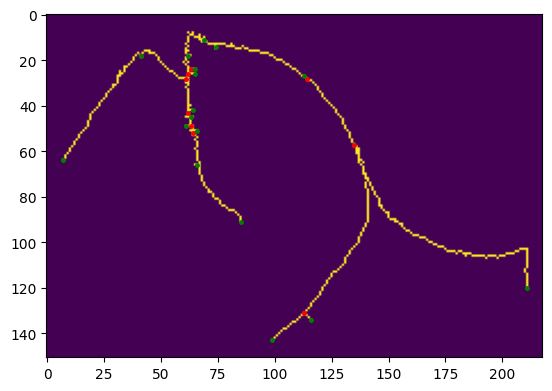

In [22]:
plt.figure()
plt.imshow(skel.max(axis=2))
plt.plot([p[0][1] for p in bifur_points], [p[0][0] for p in bifur_points], 'r.', markersize=5)
plt.plot([p[0][1] for p in leaf_points], [p[0][0] for p in leaf_points], 'g.', markersize=5)

In [286]:
skel.shape

(260, 209, 212)

##### Get aorta to find the roots of the kranskarl. And also to define the inflow surfaces to cut with later.

In [ ]:
from skimage.segmentation import find_boundaries
import scipy.ndimage as ndi
import matplotlib.pyplot as plt
from skimage.morphology import  ball


In [441]:
def get_aorta(ctimg, ccs):
    aorta = cc3d.connected_components((ctimg>300)&(ctimg<800)&(ccs==0), connectivity=6)
    aortastat = cc3d.statistics(aorta)
    aortaidx = np.argsort(aortastat['voxel_counts'])
    biggest_three = aortaidx[-4:-1]

    from_center = []
    roundness = []
    from_center_y = []
    for big in biggest_three: #check that it exists at all in this slice
        newcc = cc3d.connected_components(aorta[:,:,-3]==big, connectivity=8)
        statsbig = cc3d.statistics(newcc)
        #check if it exists in the slice at all:
        if len(statsbig['voxel_counts'])==1: #ie only bckg component
            from_center.append(np.inf)
            roundness.append(np.inf)
            from_center_y.append(np.inf)
            continue
        use = np.argsort(statsbig['voxel_counts'])[-2]
        bbx = statsbig['bounding_boxes'][use]
        centr = statsbig['centroids'][use]
        from_center.append(np.square(centr-np.array(aorta.shape[:-1])/2).sum())
        roundness.append(np.abs((bbx[0].stop-bbx[0].start)/(bbx[1].stop-bbx[1].start)-1))
        from_center_y.append(np.abs(centr[1]-np.array(aorta.shape[1])/2))

    #best_by_center = biggest_three[np.argmin(from_center)]
    #best_by_roundness = biggest_three[np.argmin(roundness)]
    #best_by_center_y = biggest_three[np.argmin(from_center_y)]

    # first choose two best ones by center, discard the third one
    discard = np.argsort(from_center)[-1]
    roundness[discard] = np.inf
    from_center_y[discard] = np.inf
    #now among the two best by center choose the one that's also best by roundness or center_y
    best_by_center_y = np.argmin(from_center_y)
    best_by_roundness = np.argmin(roundness)
    if best_by_center_y != best_by_roundness:
        print(".      oh boy...")

    bst = biggest_three[best_by_center_y]

    #print(best_by_roundness, best_by_center_y, bst)
    return aorta==bst

In [ ]:
aorta = get_aorta(ctimg, ccs)
new = np.zeros_like(aorta)
new[...,-2:] = aorta[...,-2:]
previous = aorta[..., -3]

for idn in range(aorta.shape[2]-4,-1,-1):
    next = aorta[..., idn]


In [428]:
#IDEA ZA AORTO: find kje se zacnje, to naj bo tvoj sead, grow, ampak tako da prej odstranis svojo segmentacijo (malo dilated) s slike. Tam kje reagion growing 
# zadane tvojo segmentacijo, tam je iztek v aorto
aorta = cc3d.connected_components((ctimg>300)&(ctimg<800)&(ccs==0), connectivity=6)
aortastat = cc3d.statistics(aorta)
#assume the largest component is aorta with stuff around
aortaidx = np.argsort(aortastat['voxel_counts'])
#need a fix; sometimes it finds spine. So b should be as close to the center. Maybe enough
#  to check that only in the first slice(in x and y)!
#maybe enough to check among the first three biggest ccs to see which of them is 
# closest to the centre in 2d
biggest_three = aortaidx[-4:-1] #last one is of course background, so that one we ignore. 

#c=np.zeros_like(aorta, dtype=np.uint8)
#c[aorta==biggest_three[0]] = 1
#c[aorta==biggest_three[1]] = 2
#c[aorta==biggest_three[2]] = 3
#nib.save(nib.Nifti1Image(c, img.affine, img.header), "/Users/evabreznik/Desktop/aortatest.nii.gz")


#dont take just the one closer to center - between the first two closest to center take the one that's higher up!
# ie higher indeces in the second dimension.  If this doesnt work, you can try with roundness...
from_center = []
for big in biggest_three:
    aortacomp = aorta[:,:,-3]==big #take -2, cause some images are weird; like nothings in the first slice...
    com = np.square(ndi.center_of_mass(aortacomp)-np.array(aortacomp.shape)/2).sum()
    if np.isnan(com):
        com = np.inf
    from_center.append(com) 
    
assert len(from_center)>0, "Redo with lower slice (-4 recimo)"
print(biggest_three, from_center, np.argmin(from_center))


cands = [from_center[i] for i in np.argsort(from_center)[-2:]] #if there are two similar ones, take the one that's higher up!

statsaorta = cc3d.statistics(aorta[:,:,-3])
from_centers = [np.square(statsaorta['centroids'][i]-np.array(aortacomp.shape)/2).sum() for i in biggest_three]
#get 2 best by checking center position
twobest = np.argsort(from_centers)#[-2:]

bbs = [statsaorta['bounding_boxes'][i] for i in biggest_three[twobest]]
far_up_y = [bbx[0].start for bbx in bbs] #higher is better-ish
quasi_roundness = [np.abs((bbx[0].stop-bbx[0].start)-(bbx[1].stop-bbx[1].start)) for bbx in bbs] #closer to 1 is more round
#now choose according to all:
best_idx = [np.argmax(far_up_y), np.argmin(quasi_roundness)]
if best_idx[0]!=best_idx[1]:
    print("Oh boy")
best1 = biggest_three[twobest[best_idx[0]]]
best2 = biggest_three[twobest[best_idx[1]]]


#best one:
bst = biggest_three[np.argmin(from_center)]
print(from_center, bst, best1, best2)
#aorta = aorta==bst


#IDEA: you could remove debris slicewise: at first slice take that 2d cc (out of the 3d cc) which is most in the centre and round. 
#   then in the next slices take only that 2d c that is directly connected to the chosen one above. 
#   this way you get aorta without stuff around. Except LVOT which is usually connected. So for now we'll skip that. 
#and just directly calc where the labels connect
#ALSO: due to how the skeletonization works, the inflow node leaf will not be directly at the inflow, but a bit more in. 
#Instead do this: to get inflow surface ckeck where aorta and original label map overlap. (ccs). 
#   after that you know that the leaf node closest to that overlap is the inflow. so you can set that as a leaf node if you need. 
#   you can also fix that leaf - delete it and use the overlap as the correct leaf instead!

aortatmp = ndi.binary_dilation(aorta[bb[0], bb[1], bb[2]], structure=ball(3)) #dilate a bit so you get more overlap

[   1   24 1268] [9403.605198000769, 54798.30407913031, 9584.68199542542] 0
[9403.605198000769, 54798.30407913031, 9584.68199542542] 1 24 24


In [430]:
aortaidx[-5:]

array([ 575,    1,   24, 1268,    0])

In [421]:
far_up_y

[182, 67, 223]

In [422]:
best_idx

[2, 2]

In [423]:
quasi_roundness

[29, 128, 15]

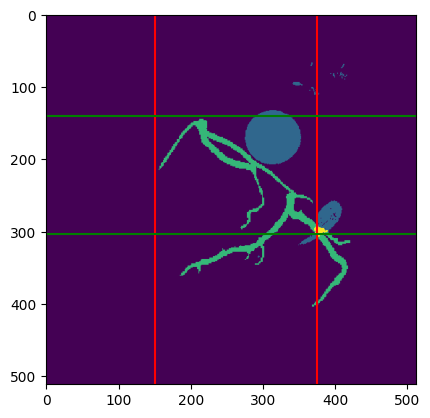

In [439]:
aorta = cc3d.connected_components((ctimg>300)&(ctimg<800)&(ccs==0), connectivity=6)
plt.figure()
plt.imshow((aorta[:,:,-3]==bst)*1 + 2*(ccs.max(axis=2)>0))
plt.plot(bb[1].start*np.ones(512), np.arange(512), 'r-')
plt.plot(bb[1].stop*np.ones(512), np.arange(512), 'r-')
plt.plot(np.arange(512), bb[0].start*np.ones(512), 'g-')
plt.plot(np.arange(512), bb[0].stop*np.ones(512), 'g-')


In [ ]:
#NOW NACIN AORTE
#1. cc3d na 3d, zberi najvecje tri objekte
#2. poglej na slajs -2 ali -3, za vsakega od najvecjih treh objektov najdi najvecji 2D cc
#3. delaj s temi 2d ccji: poglej kateri je najblizje centru, kateri najbolj round.. 

def get_aorta(ctimg, ccs):
    aorta = cc3d.connected_components((ctimg>300)&(ctimg<800)&(ccs==0), connectivity=6)
    aortastat = cc3d.statistics(aorta)
    aortaidx = np.argsort(aortastat['voxel_counts'])
    biggest_three = aortaidx[-4:-1]

    from_center = []
    roundness = []
    from_center_y = []
    for big in biggest_three: #check that it exists at all in this slice
        newcc = cc3d.connected_components(aorta[:,:,-3]==big, connectivity=8)
        statsbig = cc3d.statistics(newcc)
        use = np.argsort(statsbig['voxel_counts'])[-2]
        bbx = statsbig['bounding_boxes'][use]
        centr = statsbig['centroids'][use]
        from_center.append(np.square(centr-np.array(aorta.shape[:-1])/2).sum())
        roundness.append(np.abs((bbx[0].stop-bbx[0].start)/(bbx[1].stop-bbx[1].start)-1))
        from_center_y.append(np.abs(centr[1]-np.array(aorta.shape[1])/2))

    #best_by_center = biggest_three[np.argmin(from_center)]
    #best_by_roundness = biggest_three[np.argmin(roundness)]
    #best_by_center_y = biggest_three[np.argmin(from_center_y)]

    # first choose two best ones by center, discard the third one
    discard = np.argsort(from_center)[-1]
    roundness[discard] = np.inf
    from_center_y[discard] = np.inf
    #now among the two best by center choose the one that's also best by roundness or center_y
    best_by_center_y = np.argmin(from_center_y)
    best_by_roundness = np.argmin(roundness)
    if best_by_center_y != best_by_roundness:
        print("oh boy")

    bst = biggest_three[best_by_center_y]

    print(best_by_roundness, best_by_center_y, bst)
    return aorta==bst

2 2 1268


In [435]:
(from_center, from_center_y, roundness)

([9403.605198000769, 54798.30407913031, 9584.68199542542],
 [85.49803921568628, 234.08469721767597, 74.51585836549759],
 [1.1153846153846154, 0.3125, 0.9014084507042253])

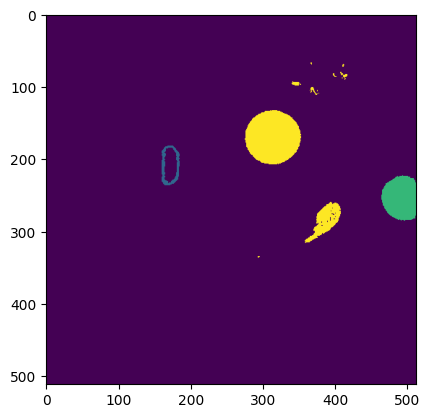

In [390]:
plt.figure()
plt.imshow((aorta[:,:,-2]==biggest_three[0])*1+2*(aorta[:,:,-2]==biggest_three[1])+3*(aorta[:,:,-2]==biggest_three[2]))

In [317]:
#zblj = np.zeros_like(ctimg, dtype=np.uint8)
#zblj[*bb] = (aortatmpx*2+label).astype(np.uint8)

#nib.save(nib.Nifti1Image(zblj, img.affine, img.header), "/Users/evabreznik/Desktop/aorta.nii.gz")
nib.save(nib.Nifti1Image(aortatmpx*2+mask, img.affine, img.header), "/Users/evabreznik/Desktop/aorta.nii.gz")

##### Now get graph connectivity and lengths of different parts

In [231]:
broken = skel + clusters #remove ths node clusters from the skeleton imgs, then run the cc3d again on the "broken" image
# work with skel and label, as they are already within bounding box, like the clusters
#better: broken = skel+clusters (to do a multilabel cc3d; all clusters will then shift to +1, since all clusters ARE part of skel). Then you can check the boundaries/graph from cc3d and will get the connectivity directly!
#just keep in mind that the clusters themselves have been shifted; the number of cc you get out/in the graph via cc3d is NOT directly the id of a cluster!!

parts, nr_parts = cc3d.connected_components(broken, connectivity=26, return_N=True)
assert nr_parts>len(bifur_points)*2+len(leaf_points), (nr_parts, len(bifur_points), len(leaf_points)) #sanity check that the clusters really somewhat appropriately break the skeleton.

lengths = cc3d.statistics(parts)['voxel_counts']
#you need to also figure out which component connects via which cluster
edges = cc3d.region_graph(parts, connectivity=26) #a set of (i1,i2) where i1 and i2 components are connected

#now we also need mapping between component id and actual cluster ids
#the mappings below contain only the clusters/components belonging to bifur/leaves, not the lines in between
comp_to_cluster = {}
#cluster_to_comp = {}
for bifur in bifur_points+leaf_points:
    comp_id = parts[bifur[0]]
    if comp_id in comp_to_cluster:
        print("issue; component ", comp_id, "mapped to two clusters:", comp_to_cluster[comp_id], bifur)
    comp_to_cluster[comp_id] = bifur
    #cluster_to_comp[bifur] = comp_id

#rearrange the edges such that you instead of (c1, l), (l,c2) have only edges between 
# clusters and the length between is a weight: (c1, c2):length(l)
new_edges = {} # l:[c1,c2,c3...] if l connected to clusters c1-3. in principle any newedges[l]should be 2 long!
for edge in edges:
    if edge[0] in comp_to_cluster: #its a bifur/leaf point
        assert edge[1] not in comp_to_cluster, (edge, comp_to_cluster) #sanity check that you dont have cluster-cluster edge
        if edge[1] in new_edges:
            new_edges[edge[1]].append(edge[0])
        else:
            new_edges[edge[1]] = [edge[0]]
    elif edge[1] in comp_to_cluster: #its a bifur/leaf point
        assert edge[0] not in comp_to_cluster, (edge, comp_to_cluster) #sanity check that you dont have cluster-cluster edge
        if edge[0] in new_edges:
            new_edges[edge[0]].append(edge[1])
        else:
            new_edges[edge[0]] = [edge[1]]

#do a check to confirm that all clusters are accounted for and length of each value is 2. 
assert np.all([len(v)==2 for v in new_edges.values()]), new_edges
assert set(comp_to_cluster.keys())==set(np.array(list(new_edges.values())).flatten()), (comp_to_cluster.keys(), set(np.array(list(new_edges.values())).flatten())) #sanity check that all clusters are accounted for

new_edges = {tuple(v): (k,lengths[k]) for k,v in new_edges.items()} #now the edges are (c1,c2):length



##### Filter the graph according to the length and the width of the vessel at each segment

In [232]:
labelwidth = ndi.distance_transform_edt(label, sampling=voxelsize) #distance from the background, so you get radius
widths = {k:labelwidth[parts==v[0]].mean() for k,v in new_edges.items()}

Text(0.5, 1.0, 'Vessel graph (filtered)')

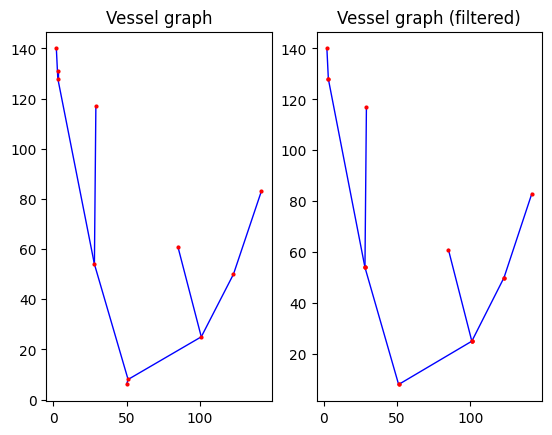

In [233]:
#let's illustrate it
import matplotlib.pyplot as plt

i=2
j=0
plt.figure()
plt.subplot(1,2,1)
#plot a projection of the vessel graph, with all clusters and connections
for edge in new_edges:
    c1, c2 = comp_to_cluster[edge[0]][0], comp_to_cluster[edge[1]][0]
    plt.plot([c1[i], c2[i]], [c1[j], c2[j]], 'b-', linewidth=1) #plot all edges
plt.plot([comp_to_cluster[c][0][i] for c in comp_to_cluster], [comp_to_cluster[c][0][j] for c in comp_to_cluster], 'ro', markersize=2) #plot all clusters
plt.title("Vessel graph")
plt.subplot(1,2,2)
#plot a projection of the vessel graph, with all clusters and connections, without the too small branches
for ne in new_edges:
    if new_edges[ne][1]>5 and widths[ne]>=np.mean(voxelsize):
        c1, c2 = comp_to_cluster[ne[0]][0], comp_to_cluster[ne[1]][0]
        plt.plot([c1[i], c2[i]], [c1[j], c2[j]], 'b-', linewidth=1) #plot this edge 
        plt.plot([c1[i], c2[i]], [c1[j], c2[j]], 'ro', markersize=2) #plot the two clusters
plt.title("Vessel graph (filtered)")

In [234]:
#filter according to the length. Allow edge if at least 5 voxels long for example
#filter according to the width. Allow edge if at least mean voxel size in radius (on average across the edge)
new_edges = {k:v for k,v in new_edges.items() if v[1]>=5 and widths[k]>=np.mean(voxelsize)}

# 3. INFLATE MIB to get back the volume, but smoothed

In [261]:
# keep only those labels that are ok according to your filtering; this will basically trim your skeleton.
allowed_parts = set([k[0] for k in new_edges.keys()]+[k[1] for k in new_edges.keys()]+[v[0] for v in new_edges.values()])
recovered_skeleton = np.isin(parts,list(allowed_parts))

In [268]:
#now inflate the skeleton according to the distance map. 
#but write it also into appropriate size, since you've been working within a boundary box
recovered_vessels = np.zeros_like(ccs, dtype=np.uint8)
shp = recovered_skeleton.shape
for vox in np.argwhere(recovered_skeleton):
    r = labelwidth[tuple(vox)]
    rr = int(np.ceil(r/voxelsize[0]))
    cc = int(np.ceil(r/voxelsize[1]))
    zz = int(np.ceil(r/voxelsize[2]))
    recovered_vessels[*bb][max(0,vox[0]-rr):min(shp[0],vox[0]+rr+1), 
                       max(0,vox[1]-cc):min(shp[1],vox[1]+cc+1), 
                       max(0,vox[2]-zz):min(shp[2],vox[2]+zz+1)] = ndi.binary_dilation(
                                recovered_skeleton[max(0,vox[0]-rr):min(shp[0],vox[0]+rr+1), 
                                                   max(0,vox[1]-cc):min(shp[1],vox[1]+cc+1), 
                                                   max(0,vox[2]-zz):min(shp[2],vox[2]+zz+1)], 
                                                   structure=ball(max(rr,cc,zz)))




# 4. Set Inflow surfaces

In [269]:
inflow = np.nonzero(aortatmp&recovered_vessels[*bb])
inflow_centroid = np.array([x.mean() for x in inflow]) #average vsake koordinate
closest_leaf_point = np.argmin([np.power(np.array(lfp[0])-inflow_centroid,2).sum() for lfp in leaf_points])
closest_leaf_point = leaf_points[closest_leaf_point][0]

def _unit(v, eps=1e-12):
    n = np.linalg.norm(v)
    return v / (n + eps)


offset_dist = 0 #nudge down along "centerline" a bit
normal = _unit(np.array(closest_leaf_point) - inflow_centroid)
cutoff_point = np.array(closest_leaf_point) + offset_dist * normal
#now check what is on the right side of the plane to be kept, and remove the rest. 

#if it takes too long, make a bounding box close around the overlap("inflow")
off = max(offset_dist*2, 10)
inflow_bb = tuple(slice(x.min()-off, x.max()+off) for x in inflow)
local_cutoff_point = cutoff_point - np.array([x.min()-off for x in inflow])

#TODO: before cutting, do also a check that at the cutoff point the vector along the 
# skeleton distally doesnt have too small angle.
#or a different approach; add more vessel from the end of the skeleton towards the overlap
# using a valj... ie extend the vessel into the aorta...
#then it should be fine to cut


#Cut away coronary voxels by the half-space (x - cutoff_pt)·n >= 0 keeps distal side
tmp_cutout = recovered_vessels[*bb][*inflow_bb].copy()
coro_local = np.argwhere(tmp_cutout)
signed = (coro_local - local_cutoff_point) @ normal       # (N,)
#keep = signed >= 0.0      # distal side
remove = signed < 0.0      # distal side
voxels_to_remove = coro_local[remove]
#now update the segmentation by the cut: [*inflow_bb]
tmp_cutout[voxels_to_remove[:,0],voxels_to_remove[:,1],voxels_to_remove[:,2]] = 0 
recovered_vessels[*bb][*inflow_bb] = tmp_cutout

# 5. DONE. Save Fixed image. Maybe some smoothing needed? Then export to STL. 

Export can be done manually or maybe via slicer API. Also, is tere another way? To also force the cutoff plane to be nice and straight?

In [270]:
nib.save(nib.Nifti1Image(recovered_vessels.astype(np.uint8), img.affine, img.header), "/Users/evabreznik/Desktop/recovered_skeleton2.nii.gz")

In [272]:
voxelsize


(0.378906, 0.378906, 0.625)